# Time-Series Forecasting: Predicting Stock Prices Using An LSTM Model

In this practice, we are going to use the stock price history data of TESLA, which is available free from Yahoo Finance here: https://finance.yahoo.com/quote/TSLA/history?period1=1436486400&period2=1594339200&interval=1d&filter=history&frequency=1d

### Load Data
print out the first 5 rows

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split



df=pd.read_csv("TSLA.csv")
print('Number of rows and columns:', df.shape)
df.head()

Number of rows and columns: (1259, 7)


,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-07-10,52.444000,52.599998,51.563999,51.830002,51.830002,13054500
1,2015-07-13,52.450001,52.509998,51.209999,52.431999,52.431999,14801500
2,2015-07-14,52.419998,53.198002,52.102001,53.130001,53.130001,9538000
3,2015-07-15,53.348000,53.498001,52.416000,52.627998,52.627998,10108000
4,2015-07-16,52.844002,53.439999,52.632000,53.335999,53.335999,8080000


### Plot the "Close" stock price based on Date

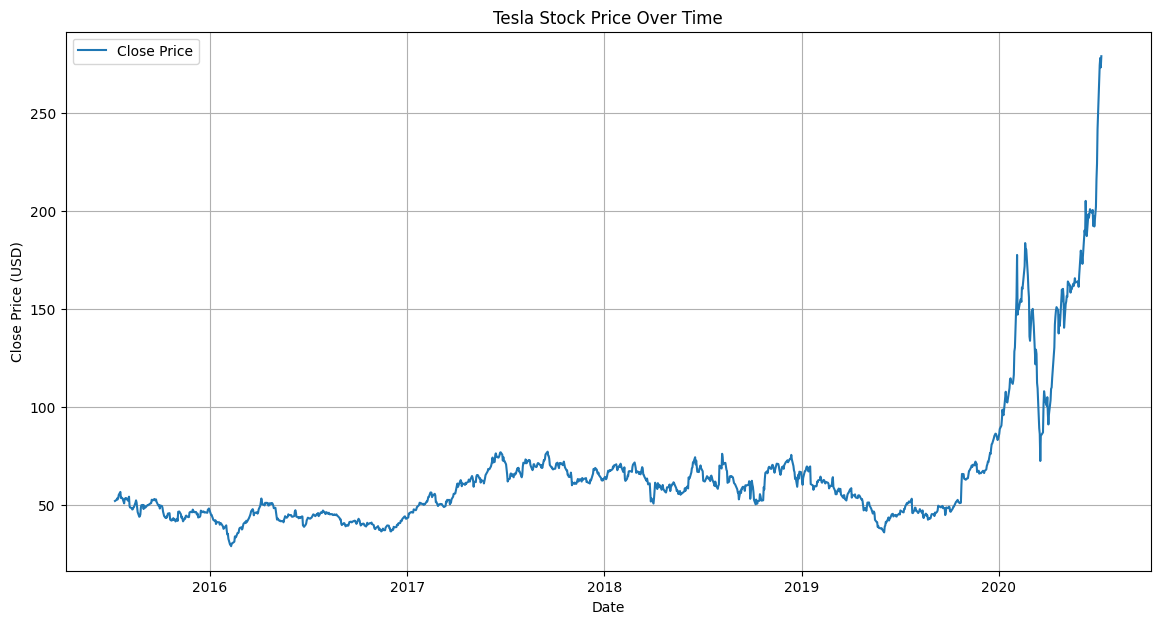

In [9]:
# Plot the "Close" stock price based on Date
plt.figure(figsize=(14, 7))
plt.plot(pd.to_datetime(df['Date']), df['Close'], label='Close Price')
plt.title('Tesla Stock Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

### Extract the column values that you are going to use from pandas dataframe
Here we are going to use the "Close" stock price to do the forecasting

In [10]:
stock = df.iloc[:, 4:5]
# or you can use this following:
# stock = df[["Close"]]

### Get values from dataframe which returns as numpy array

In [11]:
dataset = stock.values
close_prices = stock.values
close_prices = close_prices.reshape(-1, 1)

### Normalize the data with Min-Max Normalization

In [12]:
from sklearn.preprocessing import MinMaxScaler

# normalizing the data
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
scaled_data = scaler.fit_transform(close_prices)

### split the data into training and test
using first 800 rows for training and the rest 459 for testing

In [13]:
train, test = train_test_split(dataset, test_size=459, shuffle=False)

print(train.shape)
print(test.shape)

(800, 1)
(459, 1)


### Create the dataset that we are going to feed to LSTM
Define the function to create the dataset, with time (lag) and dataset as the function parmenters/arguments. 

Then we apply this function on our training and testing dataset with a time-step of 60

In [14]:
# Define the function to create the dataset
def create_dataset(data, time_step):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

# Define the time step (lag)
time_step = 60

# Create training and testing datasets
X_train, y_train = create_dataset(train, time_step)
X_test, y_test = create_dataset(test, time_step)

In [15]:
# check data shape
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((739, 60), (739,), (398, 60), (398,))

### Reshape the data to the input format that required by LSTM
Format that required by LSTM: (samples_size, time-step, features).

In [16]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

### Build a LSTM model
Build a LSTM model with 4 LSTM layer, and each layer with a 50 units/nodes. After each LSTM layer, add a dropout layer with 20% dropout rate. At last, apply a dense layer. Remember to define input_shape in the first layer and set return_sequences = True for all LSTM layer except the layer LSTM layer.

In [17]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(time_step, 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dense(units=1))

### Compile and train the model
use adam as optimizer and mean_squared_error as the loss function. use batch_size of 32 and epochs of 100 for training, set validation_data as the test dataset to monitor the training process

In [18]:
model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, validation_data = (X_test, y_test))

model.summary()



Epoch 1/100

24/24 [==============================] - 7s 93ms/step - loss: 0.0023 - val_loss: 0.0173
Epoch 2/100
24/24 [==============================] - 1s 46ms/step - loss: 4.9762e-04 - val_loss: 0.0089
Epoch 3/100
24/24 [==============================] - 1s 47ms/step - loss: 3.7203e-04 - val_loss: 0.0086
Epoch 4/100
24/24 [==============================] - 1s 48ms/step - loss: 3.8046e-04 - val_loss: 0.0065
Epoch 5/100
24/24 [==============================] - 1s 48ms/step - loss: 3.6057e-04 - val_loss: 0.0094
Epoch 6/100
24/24 [==============================] - 1s 47ms/step - loss: 3.6497e-04 - val_loss: 0.0069
Epoch 7/100
24/24 [==============================] - 1s 48ms/step - loss: 3.4690e-04 - val_loss: 0.0068
Epoch 8/100
24/24 [==============================] - 1s 47ms/step - loss: 3.1423e-04 - val_loss: 0.0074
Epoch 9/100
24/24 [==============================] - 1s 46ms/step - loss: 3.1719e-04 - val_loss: 0.0085
Epoch 10/100
24/24 [==============================] - 1s 47ms/step

### Make Predictions
apply model to both training set and testing set

In [19]:
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

13/13 [==============================] - 0s 12ms/step


### Inverting predictions
transform predictions back with the defined scaler

In [20]:
train_predict = scaler.inverse_transform(train_predictions)
test_Y = scaler.inverse_transform(y_test.reshape(-1, 1))
test_predict = scaler.inverse_transform(test_predictions)
train_Y = scaler.inverse_transform(y_train.reshape(-1, 1))

### Evaluate model performance for both Training and Testing (based on RMSE and R squared)

In [21]:
# Calculate RMSE and R² for training data
train_rmse = math.sqrt(mean_squared_error(train_Y, train_predict))
train_r2 = r2_score(train_Y, train_predict)

# Calculate RMSE and R² for testing data
test_rmse = math.sqrt(mean_squared_error(test_Y, test_predict))
test_r2 = r2_score(test_Y, test_predict)

# Print the results
print(f'Training RMSE: {train_rmse}')
print(f'Training R²: {train_r2}')
print(f'Testing RMSE: {test_rmse}')
print(f'Testing R²: {test_r2}')

Training RMSE: 2.166099652813873
Training R²: 0.9664102960164311
Testing RMSE: 14.384401165890349
Testing R²: 0.9171813694303687


### Plot the orginal Data and the Predictions

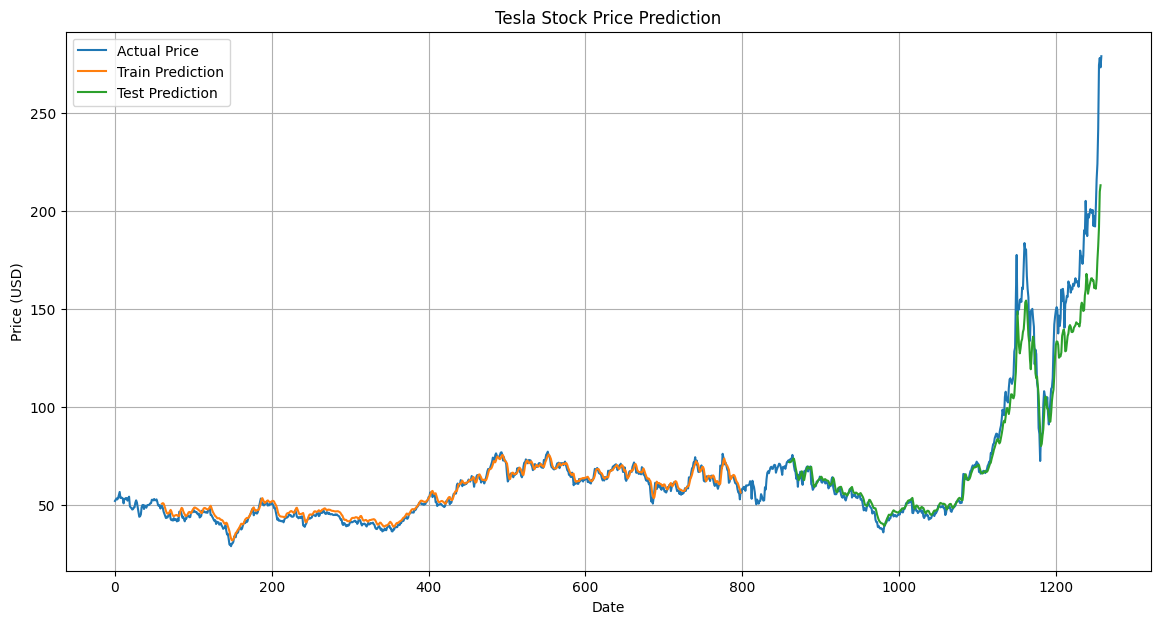

In [22]:
train_plot = np.empty_like(scaled_data)
train_plot[:, :] = np.nan
train_plot[time_step:len(train_predict) + time_step, :] = train_predict

test_plot = np.empty_like(scaled_data)
test_plot[:, :] = np.nan
test_plot[len(train_predict) + (time_step * 2) + 1:len(scaled_data) - 1, :] = test_predict

plt.figure(figsize=(14, 7))
plt.plot(scaler.inverse_transform(scaled_data), label='Actual Price')
plt.plot(train_plot, label='Train Prediction')
plt.plot(test_plot, label='Test Prediction')
plt.title('Tesla Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()